In [2]:
#!pip install --quiet glvis
import numpy as np
import matplotlib.pyplot as plt
from  bfp import *
import mfem.ser as mfem
#from mfem.common.arg_parser import ArgParser
from glvis import glvis, GlvisData
import seaborn as sns
import pandas as pd

In [3]:
class EDependentCoefficient(mfem.PyCoefficient):
    def __init__(self, xs_t_data, E_start, E_end):
        super(EDependentCoefficient, self).__init__()
        self.E_start = E_start
        self.E_end = E_end
        if isinstance(xs_t_data, (int, float)):
            self.constant = True
            self.constant_value = float(xs_t_data)
        else:
            self.constant = False
            self.xs_t_data = xs_t_data
            self.n_groups = len(xs_t_data)
            self.E_bins = np.linspace(E_start, E_end, self.n_groups + 1)

    def EvalValue(self, x):
        if self.constant:
            return self.constant_value
        E = x[1]
        for i in range(self.n_groups - 1):
            if np.isclose(E, self.E_bins[i+1]):
                return float(self.xs_t_data[i+1])
            if E <= self.E_bins[i] and E > self.E_bins[i+1]:
                return float(self.xs_t_data[i])
        return float(self.xs_t_data[-1])

class XDependentCoefficient(mfem.PyCoefficient):

    def __init__(self, xs_t_data, x_start, x_end):
        super(XDependentCoefficient, self).__init__()
        self.x_start = x_start
        self.x_end = x_end
        if isinstance(xs_t_data, (int, float)):
            self.constant = True
            self.constant_value = float(xs_t_data)
        else:
            self.constant = False
            self.xs_t_data = xs_t_data
            self.n_groups = len(xs_t_data)
            self.x_bins = np.linspace(x_start, x_end, self.n_groups + 1)

    def EvalValue(self, x):
        if self.constant:
            return self.constant_value

        x_val = x[0]
        for i in range(self.n_groups - 1):
            if np.isclose(x_val, self.x_bins[i+1]):
                return float(self.xs_t_data[i+1])
            if self.x_bins[i] <= x_val < self.x_bins[i+1]:
                return float(self.xs_t_data[i])
        return float(self.xs_t_data[-1])

class MyVectorCoefficient(mfem.VectorConstantCoefficient):
    def __init__(self, mu_coeff, S_coeff):
        super(MyVectorCoefficient, self).__init__(2)
        self.mu_coeff = mu_coeff 
        self.S_coeff = S_coeff

    def EvalValue(self, x):
        mu_val = self.mu_coeff.EvalValue(x) 
        S_val = self.S_coeff.EvalValue(x) 
        return [mu_val, S_val]
    
class InflowCoefficientSN(mfem.PyCoefficient):
    def __init__(self, inflow, mu):
        super(InflowCoefficientSN, self).__init__()
        self.inflow = inflow
        self.mu = mu
    def EvalValue(self, x):
        if self.mu > 0:
            return self.inflow
        else:
            return 0.0
        
class ConstantVector(mfem.VectorPyCoefficient):
    def __init__(self, constant):
        super(ConstantVector, self).__init__(1)
        self.constant = constant 
    def EvalValue(self, x):
        return self.constant

In [4]:
def test_EDependentCoefficient():
    xs_t_data = [0,1,2,3,4]
    coeff = EDependentCoefficient(xs_t_data, 1, 0.01)
    print(coeff.EvalValue([0.0, 1]))
    print(coeff.EvalValue([0.0, 0.802]))
    print(coeff.EvalValue([0.0, 0.604]))
    print(coeff.EvalValue([0.0, 0.406]))
    print(coeff.EvalValue([0.0, 0.208]))
    print(coeff.EvalValue([0.0, 0.01]))

def test_EDependentCoefficient_Constant():
    coeff = EDependentCoefficient(40, 0, 1)
    print(coeff.EvalValue([0.0, 1]))
    print(coeff.EvalValue([0.0, 0.802]))
    print(coeff.EvalValue([1.0, 0.604]))
    print(coeff.EvalValue([0.3, 0.406]))
    print(coeff.EvalValue([0.6, 0.208]))
    print(coeff.EvalValue([0.8, 0.01]))

#print("Test for E dependent Coefficient")
#test_EDependentCoefficient()
#print("Test for E dependent Constant Coefficient")
#test_EDependentCoefficient_Constant()

def test_XDependentCoefficientt():
    xs_t_data = [0,1,2,3,4]
    coeff = XDependentCoefficient(xs_t_data, 0, 1)
    print(coeff.EvalValue([0.0, 0.00]))
    print(coeff.EvalValue([0.2, 0.00]))
    print(coeff.EvalValue([0.4, 0.00]))
    print(coeff.EvalValue([0.6, 0.00]))
    print(coeff.EvalValue([0.8, 0.00]))
    print(coeff.EvalValue([1.0, 0.00]))

def test_XDependentCoefficient_Constant():
    coeff = XDependentCoefficient(80, 0.0, 1.0)
    print(coeff.EvalValue([0.0, 0.00]))
    print(coeff.EvalValue([0.2, 0.00]))
    print(coeff.EvalValue([0.4, 0.00]))
    print(coeff.EvalValue([0.6, 0.00]))
    print(coeff.EvalValue([0.8, 0.00]))
    print(coeff.EvalValue([1.0, 0.00]))

#print("Test for X dependent Coefficient")
#test_XDependentCoefficientt()
#print("Test for X dependent Constant Coefficient")
#test_XDependentCoefficient_Constant()

def test_MyVectorCoefficient():
    mu_data = [5,6,7,8,9]
    mu = XDependentCoefficient(mu_data, 0.0, 1.0)
    S_data = [0,1,2,3,4]
    S = EDependentCoefficient(S_data, 1.0, 0.01)
    coeff = MyVectorCoefficient(mu, S)
    print(coeff.EvalValue([0.0, 0.802]))
    print(coeff.EvalValue([0.2, 0.604]))
    print(coeff.EvalValue([0.4, 0.406]))
    print(coeff.EvalValue([0.6, 0.208]))
    print(coeff.EvalValue([0.8, 0.01]))

#print("Test for Vector Coefficient")
#test_MyVectorCoefficient()


In [ ]:
nx = 30
nE = 50
x_start = 0.0
x_end = 1.0
E_start = 1
E_end = 0.01
N_ang = 2
order = 1
inflow = 10

mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()
#marker = get_marker_for_mu(mesh, 1.0)

# btype = 0-GaussLegendre, 1 - GaussLobatto
fec = mfem.DG_FECollection(order, dim, btype=1)
fes = mfem.FiniteElementSpace(mesh, fec)
Size = fes.GetVSize()
print("Number of unknowns:", Size)

mu_vals, w_vals = gauss_legendre_dirs(N_ang)

#ess_bdr = mfem.intArray(mesh.bdr_attributes.Max())
#ess_bdr.Assign(0)
#ess_bdr[3] = 1

#ess_tdof_list = mfem.intArray()
#fes.GetEssentialTrueDofs(ess_bdr, ess_tdof_list)

S_const = 0.0
xs_t_const = 5.0
#xs_s_const = 1.0
S_arr = np.ones(nE) * S_const
E_arr = np.linspace(E_start, E_end, nE+1)

S_coeff = EDependentCoefficient(S_const, E_start, E_end)
xs_t_coeff = EDependentCoefficient(xs_t_const, E_start, E_end)
#xs_s_coeff = EDependentCoefficient(xs_s_const, E_start, E_end)
q_coeff = EDependentCoefficient(0.0, E_start, E_end)
#marker_l = mfem.intArray([4])
#marker_r = mfem.intArray([2])

# Solution
psi_mu_list = []
psi_mu = []
for mu, w in zip(mu_vals, w_vals):
    print("  Solving for mu =", mu)
    mu_coeff = ConstantCoefficient(mu)
    inflow_coeff = InflowCoefficientSN(inflow, mu)
    #marker = get_marker_for_mu(mesh, mu)
    v_coeff = MyVectorCoefficient(mu_coeff, S_coeff)
    print(f"inflow: {inflow_coeff.EvalValue([inflow, mu])}")
    print(f"v_coeff: {v_coeff.EvalValue([mu, 0.8])}")

    # Assemble Bilinear and Linear Forms
    a = mfem.BilinearForm(fes)
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coeff, -1.0))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddInteriorFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.AddBdrFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.Assemble()
    A = a.SpMat()

    b = mfem.LinearForm(fes)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coeff))
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_coeff, v_coeff, -1.0))
    b.Assemble()

    psi = mfem.GridFunction(fes)
    psi.Assign(1.0) 

    prec = mfem.GSSmoother(A)
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetPreconditioner(prec)
    solver.SetRelTol(1e-12)
    solver.SetAbsTol(1e-12)
    solver.SetMaxIter(1000)
    solver.SetKDim(30)
    solver.SetPrintLevel(1)
    solver.Mult(b, psi)
    

    g = glvis((mesh, psi), 600, 600)
    g.render()
    psi.Save("psi_hs_mu_{:.3f}.gf".format(mu))
    psi_arr = psi.GetDataArray()
    psi_mu.append(psi_arr)
    psi_mu_list.append((mu, w, psi))
    
phi = mfem.GridFunction(fes)
phi.Assign(0.0)
phi_list = []
for mu, w, psi in psi_mu_list:
    psi_w_list = psi.GetDataArray() * w
    phi_list.append(psi_w_list)
    phi.Add(w, psi)
phi_list = np.array(phi_list)
phi_list = np.sum(phi_list, axis=0)
print(phi_list)


phi.Save("phi_hs.gf")
    

: 

In [ ]:
print(psi_mu[0])


IndexError: list index out of range

In [ ]:
psi_mu[1]

IndexError: list index out of range

In [ ]:
mu_vals

[-0.5773502691896257, 0.5773502691896257]

In [ ]:
w_vals

[1.0, 1.0]

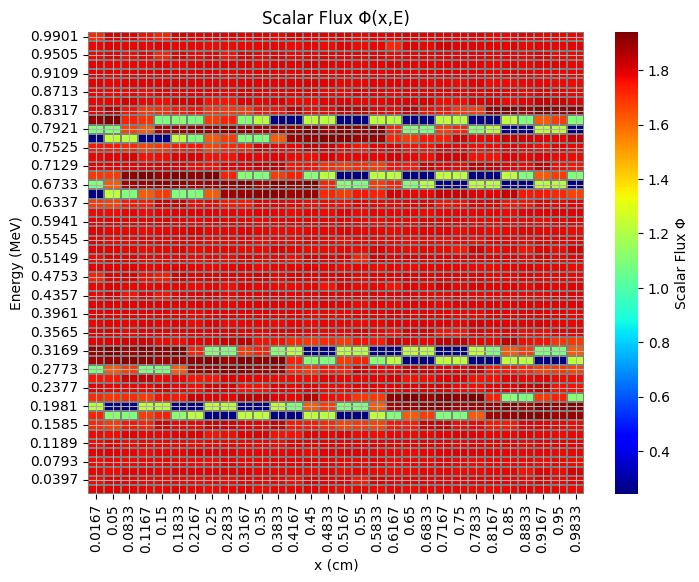

In [ ]:
HeatMap = HeatmapPlot(phi, mesh, fes)
HeatMap.plot_heatmap(x_start, x_end, nx, E_start, E_end, nE)

In [ ]:
psimelek0 = 10 * np.exp(-5*0/0.577)
psimelek0


10.0

In [ ]:
psimelek03 = 10 * np.exp(-5*0.3/0.577)
psimelek03


0.7429932741782513

In [ ]:
psi5 = np.array([5.12, 6.4 , 8.  , 8.  , 6.4 , 5.12, 5.12, 6.4 , 8.  , 8.  , 8.  , 6.4 , 6.4 , 5.12, 5.12])

In [ ]:
sorted(psi5)    

[5.12,
 5.12,
 5.12,
 5.12,
 5.12,
 6.4,
 6.4,
 6.4,
 6.4,
 6.4,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0]

In [7]:
nx = 30
nE = 50
x_start = 0.0
x_end = 1.0
E_start = 1
E_end = 0.01
N_ang = 2
order = 1
inflow = 10
mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)


File '/Users/melekderman/github/BFP/melek/mesh/usr/30x50_2D.mesh' already exists.


In [8]:
mesh.PrintInfo()


Mesh Characteristics:
Dimension          : 2
Space dimension    : 2
Number of vertices : 1581
Number of edges    : 3080
Number of elements : 1500  --  1500 Square(s)
Number of bdr elem : 160
Euler Number       : 1
h_min              : 0.0256905
h_max              : 0.0256905
kappa_min          : 1.6835
kappa_max          : 1.6835

